In [1]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [2]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [3]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [4]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\4235307656.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\4235307656.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\4235307656.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observe

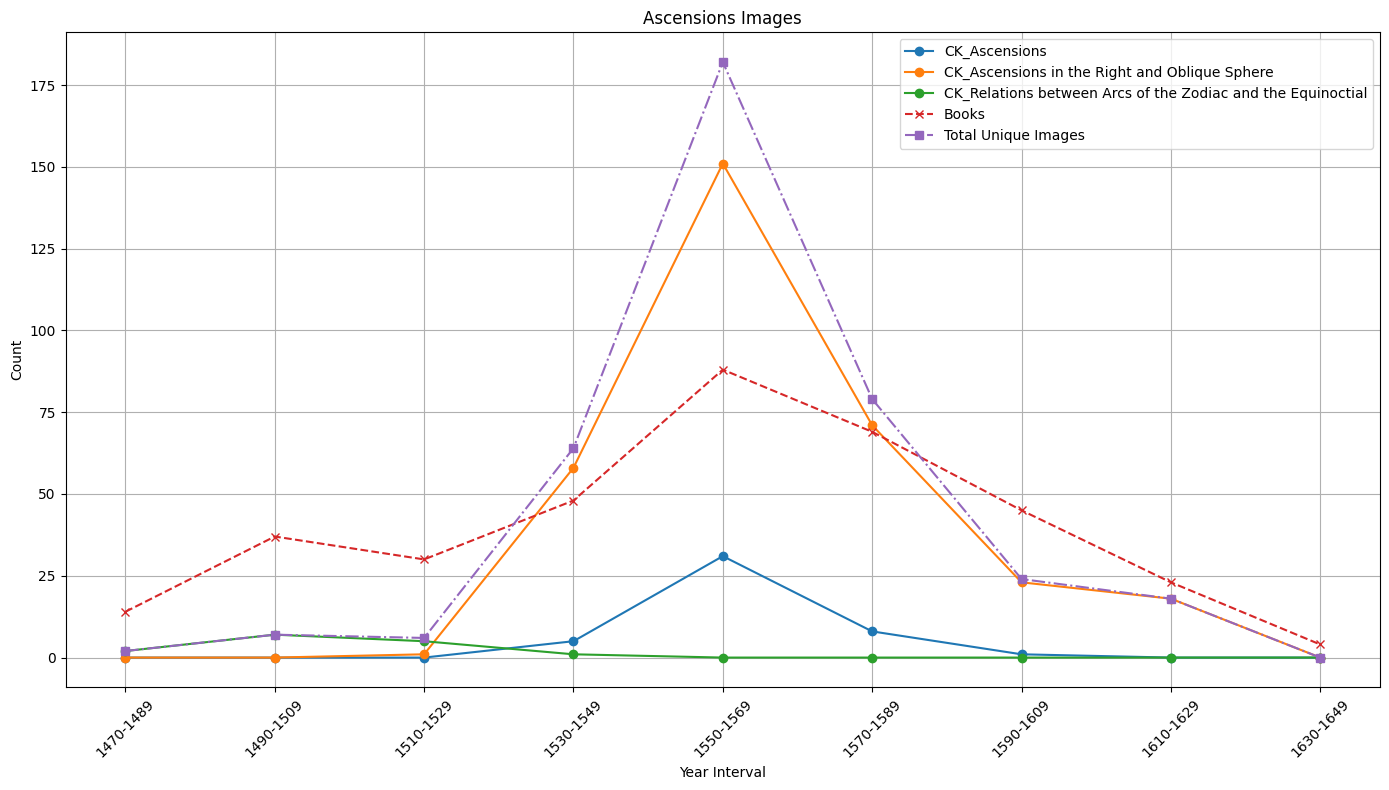

In [14]:
# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
   'CK_Ascensions', 
   'CK_Ascensions in the Right and Oblique Sphere', 
   'CK_Relations between Arcs of the Zodiac and the Equinoctial'
]

# Prepare a DataFrame for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = df['cks'].apply(lambda x: keyword == x)  # Change to exact match
    filtered_df = df[mask]
    unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = pd.merge(keyword_dfs[keywords[0]], keyword_dfs[keywords[1]], on='interval', how='outer')
for keyword in keywords[2:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval')['book'].nunique().reset_index()
unique_books_per_interval.columns = ['interval', 'unique_books']

# Create a mask for any of the keywords using exact matches
mask_any_keyword = df['cks'].apply(lambda x: any(keyword == x for keyword in keywords))

# Filter the DataFrame based on this mask
filtered_images_df = df[mask_any_keyword]

# Count unique images per interval
total_unique_images_per_interval = filtered_images_df.groupby('interval')['images'].nunique().reset_index()
total_unique_images_per_interval.columns = ['interval', 'total_unique_images']

# Merge the keyword DataFrame with the books DataFrame
final_df = pd.merge(merged_keyword_df, unique_books_per_interval, on='interval', how='outer')

# Merge with the total unique images DataFrame
final_df = pd.merge(final_df, total_unique_images_per_interval, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword
for keyword in keywords:
    plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'{keyword}', marker='o')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Books', marker='x', linestyle='--')

# Plot total unique images
plt.plot(final_df['interval'], final_df['total_unique_images'], label='Total Unique Images', marker='s', linestyle='-.')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('Ascensions Images')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
#Define keywords
#keywords = [
#   'CK_Ascensions', 
#   'CK_Ascensions in the Right and Oblique Sphere', 
#   'CK_Relations between Arcs of the Zodiac and the Equinoctial'
]

#Define a function to check if any keyword is in a string
#def contains_keywords(cks_value):
#    return any(keyword in cks_value for keyword in keywords)

# Create a boolean mask for the keywords
#mask = df['cks'].apply(contains_keywords)

# Filter the DataFrame based on the mask
#filtered_df = df[mask]

# Get the unique cluster_name values
#unique_cluster_names = filtered_df['cluster_name'].unique().tolist()

# Convert the list to a DataFrame
#unique_cluster_names_df = pd.DataFrame(unique_cluster_names, columns=['cluster_name'])

# Save the DataFrame to an Excel file
#output_file = 'ascensions.xlsx'
#unique_cluster_names_df.to_excel(output_file, index=False)


In [18]:
# Define the values to filter by
keywords = ['CK_Ascensions', 'CK_Ascensions in the Right and Oblique Sphere', 'CK_Relations between Arcs of the Zodiac and the Equinoctial']

# Create a boolean mask for filtering
mask = df['cks'].apply(lambda x: any(keyword in x for keyword in keywords))

# Filter the DataFrame
filtered_df = df[mask]

# Path to the Excel file
excel_file_path = 'C:\\Users\\nogas\\Image_data\\ascensions.xlsx'

# Load the Excel file into a DataFrame
excel_data = pd.read_excel(excel_file_path)

ascensions_visual = pd.merge(filtered_df, excel_data, on='cluster_name', how='left')

C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\1777108246.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)
C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\1777108246.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)
C:\Users\nogas\AppData\Local\Temp\ipykernel_10952\1777108246.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

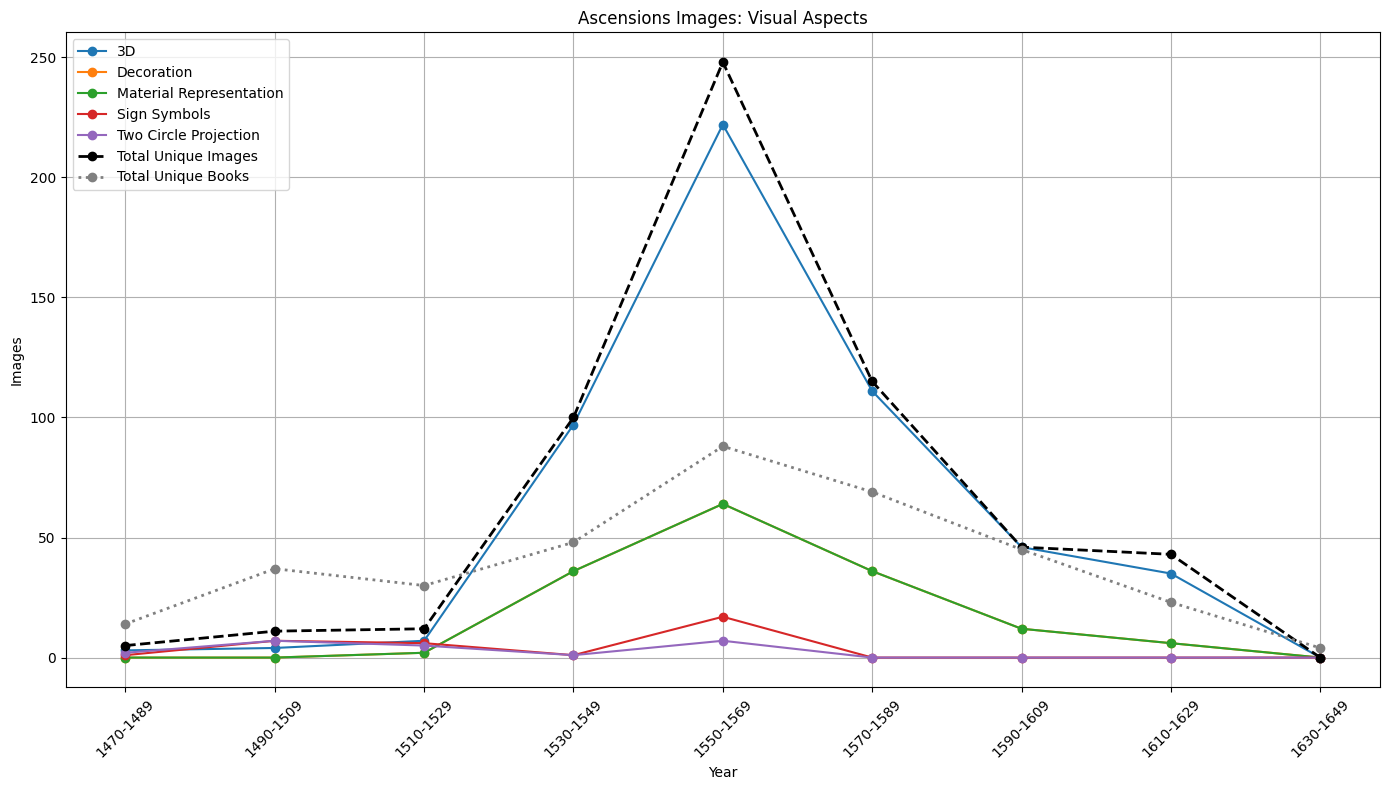

In [22]:
# Convert 'year' to int
ascensions_visual['year'] = ascensions_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
ascensions_visual['interval'] = pd.cut(ascensions_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_df = ascensions_visual[ascensions_visual[column_name] == value]
    return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Collect data with updated column names
three_d = count_unique_images_by_column('3D', 'yes')
decoration = count_unique_images_by_column('decoration', 'yes')
material_representation = count_unique_images_by_column('material representation', 'yes')
double_image = count_unique_images_by_column('double', 'yes')
signs_symbols = count_unique_images_by_column('signs symbols', 'yes')
two_circle_projection = count_unique_images_by_column('two circle two dimensional projection', 'yes')
color = count_unique_images_by_column('color', 'yes')
multiple_moments = count_unique_images_by_column('multiple moments', 'yes')

# Combine the data for lines
side_by_side_data = pd.DataFrame({
    '3D': three_d,
    'Decoration': decoration,
    'Material Representation': material_representation,
    'Sign Symbols': signs_symbols,
    'Two Circle Projection': two_circle_projection,
 
})



# Calculate total unique books and images for each interval
total_unique_books_df = books.groupby('interval')['book'].nunique().reindex(labels, fill_value=0)
total_unique_images = filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Plot lines with single y-axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category on primary y-axis
for column in side_by_side_data.columns:
    ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Plot lines for total unique images and total unique books
ax.plot(labels, total_unique_images, marker='o', linestyle='--', color='black', label='Total Unique Images', linewidth=2)
ax.plot(labels, total_unique_books_df, marker='o', linestyle=':', color='gray', label='Total Unique Books', linewidth=2)

# Formatting the plot
ax.set_xlabel('Year')
ax.set_ylabel('Images')
ax.set_title('Ascensions Images: Visual Aspects')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()